In [1]:
import bhnerf
from astropy import units
import jax

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from flax.training import checkpoints
from pathlib import Path
import ruamel.yaml as yaml
import warnings
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '6,7'
warnings.simplefilter("ignore")

Welcome to eht-imaging! v 1.2.5 



Animate synthetic recoveries
---
This notebook animates the 3D recovery across inclination angles

In [2]:
def plot_chi2(df, inc_true, plot_chi2_1=False, ax=None, xticks=range(10,90,10), figsize=(5,4), latex=True):
    if latex: 
        plt.rcParams.update({"text.usetex": True, 'font.family': 'lmodern'})
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.errorbar(df.index, np.nanmean(np.log10(df), axis=1), np.nanstd(np.log10(df), axis=1), color='tab:orange', marker='^', mfc='r', mec='r', markersize=5)
    ax.set_title(r'Inclination data-fit: $\log \chi^2(\theta | {\bf w}^\star)$', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.axvline(inc_true, color='black', linestyle='--',linewidth=1.3, label=r'$\theta_o^{\rm true}$')
    ax.legend()
    ax.set_xticks(xticks)
    if plot_chi2_1: ax.axhline(0, color='black', linestyle='--',linewidth=0.75)

In [5]:
basename = 'inc_{:.1f}.seed_{}'
recovery_path = Path('../data/synthetic_lightcurves/two_gaussians/recovery/sim2_quadrant_1_seed1_Q_0.25_intrinsic/')
with open(recovery_path.joinpath('params.yaml'), 'r') as stream:
    config = yaml.load(stream, Loader=yaml.Loader)

locals().update(config['simulation']['model'])
locals().update(config['recovery']['model'])
locals().update(config['recovery']['optimization']) 

# Read and split data
data_path = Path(config['simulation']['lightcurve_path'])
lightcurves_df = pd.read_csv(data_path)
target, t_frames = np.array(lightcurves_df[stokes]), np.array(lightcurves_df['t'])*units.hr
train_idx = t_frames <= t_start_obs*units.hr + train_split*units.min
t_train, data_train  = t_frames[train_idx], target[train_idx]

inc_true = config['simulation']['model']['inclination']
params = config['simulation']['model'] | config['recovery']['model']

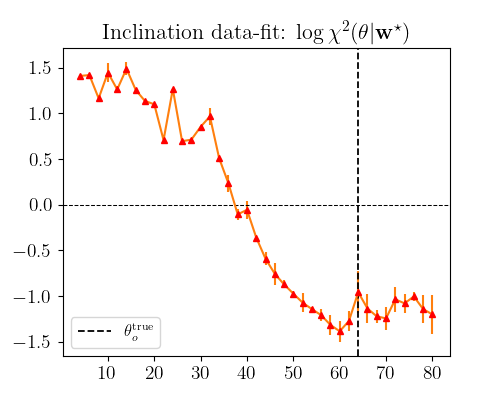

In [6]:
chi2_inc = pd.read_csv(recovery_path.joinpath('inclination_loss_subrays_10.csv'), index_col=0)
%matplotlib widget
plot_chi2(chi2_inc, inc_true, plot_chi2_1=True)

In [10]:
"""
Render images, this is time consuming
"""
seed = 2

# Ground truth volumetric emission
flare_path = Path(config['simulation']['flare_path'])
emission_flare = emission_scale * xr.load_dataarray(flare_path)
norm_const =  float(emission_flare.max())

# Renderer parameters
jit = True
resolution = 256
bh_radius = 1 + np.sqrt(1-spin**2)
cam_r = 55.
linewidth = 0.14
zenith = np.deg2rad(35)
visualizer = bhnerf.visualization.VolumeVisualizer(resolution, resolution, resolution)
visualizer.set_view(cam_r=cam_r, domain_r=rmax, azimuth=0.0, zenith=zenith)

images = []
for inc in tqdm(chi2_inc.index, desc='inc'):
    checkpoint_dir = recovery_path.joinpath(basename.format(inc, seed))
    emission_rec =  bhnerf.network.sample_checkpoint_3d(checkpoint_dir, coords=visualizer.coords, chunk=32)
    image = visualizer.render(emission_rec / norm_const, facewidth=1.9*rmax, jit=jit, 
                              bh_radius=bh_radius, linewidth=linewidth)
    images.append(image)

inc:   0%|          | 0/39 [00:00<?, ?it/s]

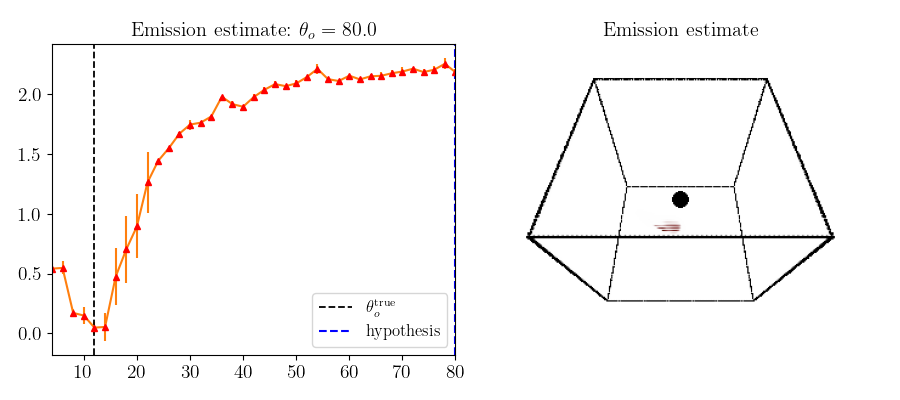

In [101]:
%matplotlib widget
output = recovery_path.joinpath('animation_chi2_3d_seed_{}.gif'.format(seed))
bhnerf.visualization.animate_chi2_3d(images, chi2_inc, fps=1, output=output)